In [7]:
import sys
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import json

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from PIL import ImageColor
plt.rcParams.update({"axes.grid" : True, 'axes.axisbelow': True, 'axes.facecolor': '#f6f6f6'})

# plt.rcParams['axes.axisbelow'] = True
# plt.rcParams['axes.facecolor'] = '#eaeaf2'

color_list = ['#2CBDFE', '#47DBCD', '#F3A0F2', '#F5B14C', '#9D2EC5', '#661D98', 
              '#CF8BA9', '#F8F32B', '#8F3985', '#A8763E', '#F1DB4B', '#71B48D', 
              '#444140', '#F9627D'
]

color_list_rgb = [ImageColor.getcolor(color, "RGB") for color in color_list]

markers_list = ['o', 'v', '^', '<', '>', 's', 'p', 'x']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

print(color_list)

['#2CBDFE', '#47DBCD', '#F3A0F2', '#F5B14C', '#9D2EC5', '#661D98', '#CF8BA9', '#F8F32B', '#8F3985', '#A8763E', '#F1DB4B', '#71B48D', '#444140', '#F9627D']


In [11]:
from matplotlib import markers

CONFIGS = [
    'freeze_all', 'freeze_encoder', 'unfreeze'
]

COLORS_CONFIGS = {config: color_list[i] for i, config in enumerate(CONFIGS)}

LABELS_CONFIG = {
    'freeze_all': 'Frozen',
    'freeze_encoder': 'Frozen-Encoder',
    'unfreeze': 'Unfrozen',
    'random': 'Without Transfer Learning'
}

PRE_TRAINED_MODELS = [
    'Murphy', 'Schroeder', 'Kumar-Roy', 'Voting', 'Intersection',
]

LABELS_PRETRAINED_MODELS = {
    'Murphy': 'Murphy et al.',
    'Schroeder': 'Schroeder et al.',
    'Kumar-Roy' : 'Kumar and Roy',
    'Voting': 'Voting',
    'Intersection': 'Intersection',
}

LABELS_METHODS = {
    'KatoNakamura': 'Kato and Nakamura',
    'Liu': 'Liu et al.',
    'Murphy': 'Murphy et al',
}

METHODS = LABELS_METHODS.keys()

COLORS_METHODS = {method: color_list[i] for i, method in enumerate(LABELS_METHODS.keys(), start=len(CONFIGS)+1)}
COLORS_PRETRAINED_MODELS = {PRE_TRAINED_MODELS[i]: color_list[j] for i, j in enumerate(range(len(CONFIGS)+len(LABELS_METHODS), len(CONFIGS)+len(LABELS_METHODS)+len(PRE_TRAINED_MODELS)))}


MARKERS_METHODS = {method: markers_list[i] for i, method in enumerate(LABELS_METHODS.keys())}

MANUAL_ANNOTATED_SCENES_IMAGES_STACK_PATH = '../../resources/sentinel/Sentinel2/manual_annotated/scenes/stack'
MANUAL_ANNOTATED_SCENES_MASKS_LEVEL1_PATH = '../../resources/sentinel/Sentinel2/manual_annotated/scenes/annotations/mask1'

METHODS_RESULTS_PATH = '../../resources/sentinel/Sentinel2/manual_annotated/evaluate_algorithms_results/5folds_mask1_array'

TRANSFER_LEARNING_RESULTS_PATH = '../../resources/transfer_learning/output/results'

METRICS = [ 'P', 'R', 'IoU', 'F-score',]


In [15]:
def read_methods_results(path):

    folds = os.listdir(path)
    data = []
    for fold in folds:
        n_samples = sorted(os.listdir(os.path.join(path, fold)))
        for method in METHODS:
            metrics_file = os.path.join(path, fold, f'{method}.json')

            with open(metrics_file) as f:
                metrics = json.load(f)

            row = {
                'fold': fold,
                'method': method,
            }

            for metric in metrics:
                row[metric] = metrics[metric]

            data.append(row)


    df_methods = pd.DataFrame(data)
    df_methods['fold'] = df_methods['fold'].apply(pd.to_numeric)

    df_methods = df_methods.drop(['tn',	'fp', 'fn',	'tp'], axis=1)
    df_methods = df_methods.fillna(0)

    return df_methods
  


def read_results_of_pretrained_models_from_path(path):
    folds = sorted(os.listdir(path))

    print(f'Num. Folds: {len(folds)}')

    data = []
    for fold in folds:

        pretrained_models = os.listdir(os.path.join(path, fold))        
        for pretrained_model in pretrained_models:
            
            for config in CONFIGS:
                metrics_file = os.path.join(path, fold, pretrained_model, f'{config}_results.json')

                with open(metrics_file) as f:
                    metrics = json.load(f)

                row = {
                    'fold': fold,
                    'config': config,
                    'pretrained_model': pretrained_model,
                }

                for metric in metrics:
                    row[metric] = metrics[metric]

                data.append(row)


    df = pd.DataFrame(data)
    df['fold'] = df['fold'].apply(pd.to_numeric)
    df['label'] = df.config.apply(lambda x : LABELS_CONFIG[x])
    df = df.drop(['tn',	'fp', 'fn',	'tp'], axis=1)
    df = df.fillna(0)

    return df

df = read_results_of_pretrained_models_from_path(os.path.join(TRANSFER_LEARNING_RESULTS_PATH, '5fold_8020_mask1_unet64f_bce_augmentation'))
df

# df.to_csv('../../resources/transfer_learning/results_pretrained_models.csv')

Num. Folds: 5


,fold,config,pretrained_model,P,R,IoU,F-score,label
0,1,freeze_all,Intersection,0.502611,0.911160,0.479131,0.647855,Frozen
1,1,freeze_encoder,Intersection,0.877047,0.775486,0.699446,0.823146,Frozen-Encoder
2,1,unfreeze,Intersection,0.981693,0.420251,0.416983,0.588550,Unfrozen
3,1,freeze_all,Voting,0.475874,0.978809,0.471021,0.640400,Frozen
4,1,freeze_encoder,Voting,0.754937,0.929969,0.714327,0.833361,Frozen-Encoder
...,...,...,...,...,...,...,...,...
70,5,freeze_encoder,Murphy,0.562916,0.906771,0.532119,0.694619,Frozen-Encoder
71,5,unfreeze,Murphy,0.723496,0.830909,0.630645,0.773491,Unfrozen
72,5,freeze_all,Kumar-Roy,0.434359,0.983448,0.431207,0.602578,Frozen
73,5,freeze_encoder,Kumar-Roy,0.716466,0.929969,0.679789,0.809374,Frozen-Encoder


In [16]:
# print ( df.groupby(['label', 'pretrained_model'])[METRICS].agg(['mean', 'std']).to_csv(decimal=',', sep=',') )

# df.groupby(['label', 'pretrained_model'])[METRICS].agg(['mean'])
df.groupby(['label', 'pretrained_model'])[METRICS].agg(['mean', 'std'])





P                   R            \
                                     mean       std      mean       std   
label          pretrained_model                                           
Frozen         Intersection      0.711783  0.124105  0.896464  0.015820   
               Kumar-Roy         0.405255  0.044901  0.986395  0.004829   
               Murphy            0.107370  0.068693  0.953116  0.005030   
               Schroeder         0.631025  0.132676  0.933442  0.009079   
               Voting            0.549228  0.042911  0.973254  0.004863   
Frozen-Encoder Intersection      0.856222  0.029263  0.845367  0.046825   
               Kumar-Roy         0.844153  0.076154  0.794382  0.095350   
               Murphy            0.791324  0.147772  0.820150  0.077305   
               Schroeder         0.922265  0.026070  0.742458  0.072399   
               Voting            0.691537  0.047471  0.945266  0.012220   
Unfrozen       Intersection      0.968245  0.012162  0.557768  0.122804   
               Kumar-Roy         0.909912  0.047150  0.726357  0.102137   
               Murphy            0.847229  0.108970  0.750658  0.089812   
               Schroeder         0.970592  0.012163  0.569254  0.141414   
               Voting            0.917319  0.048694  0.750984  0.099968   

                                      IoU             F-score            
                                     mean       std      mean       std  
label          pretrained_model                                          
Frozen         Intersection      0.654911  0.101945  0.787518  0.080353  
               Kumar-Roy         0.402840  0.043676  0.573199  0.045054  
               Murphy            0.106567  0.067996  0.187003  0.114073  
               Schroeder         0.602199  0.120975  0.745389  0.104764  
               Voting            0.540870  0.040588  0.701289  0.035256  
Frozen-Encoder Intersection      0.738602  0.022342  0.849496  0.015018  
               Kumar-Roy         0.683669  0.039276  0.811599  0.027846  
               Murphy            0.659229  0.071508  0.792721  0.055124  
               Schroeder         0.696197  0.048407  0.820129  0.033399  
               Voting            0.664166  0.037791  0.797702  0.027245  
Unfrozen       Intersection      0.546069  0.115106  0.700482  0.099306  
               Kumar-Roy         0.671599  0.065668  0.802036  0.047864  
               Murphy            0.648205  0.024327  0.786349  0.017794  
               Schroeder         0.557641  0.133304  0.708125  0.115247  
               Voting            0.697112  0.062799  0.820217  0.044266

In [18]:
for config in CONFIGS: 
    # filter_pretrained = (df['pretrained_model'] == pretrained_model)
    filter_config = (df['config'] == config)
    best_score = df[ filter_config ]['F-score'].max()
    filter_metric = (df['F-score'] == best_score)

    best_model = df[ (filter_config & filter_metric) ]

    print(best_model)

    fold      config pretrained_model         P         R      IoU   F-score  \
30     3  freeze_all     Intersection  0.801689  0.881003  0.72336  0.839477   

     label  
30  Frozen  
    fold          config pretrained_model         P         R       IoU  \
46     4  freeze_encoder     Intersection  0.847604  0.873856  0.755202   

    F-score           label  
46  0.86053  Frozen-Encoder  
    fold    config pretrained_model         P         R       IoU   F-score  \
20     2  unfreeze           Voting  0.910747  0.805455  0.746528  0.854871   

       label  
20  Unfrozen  


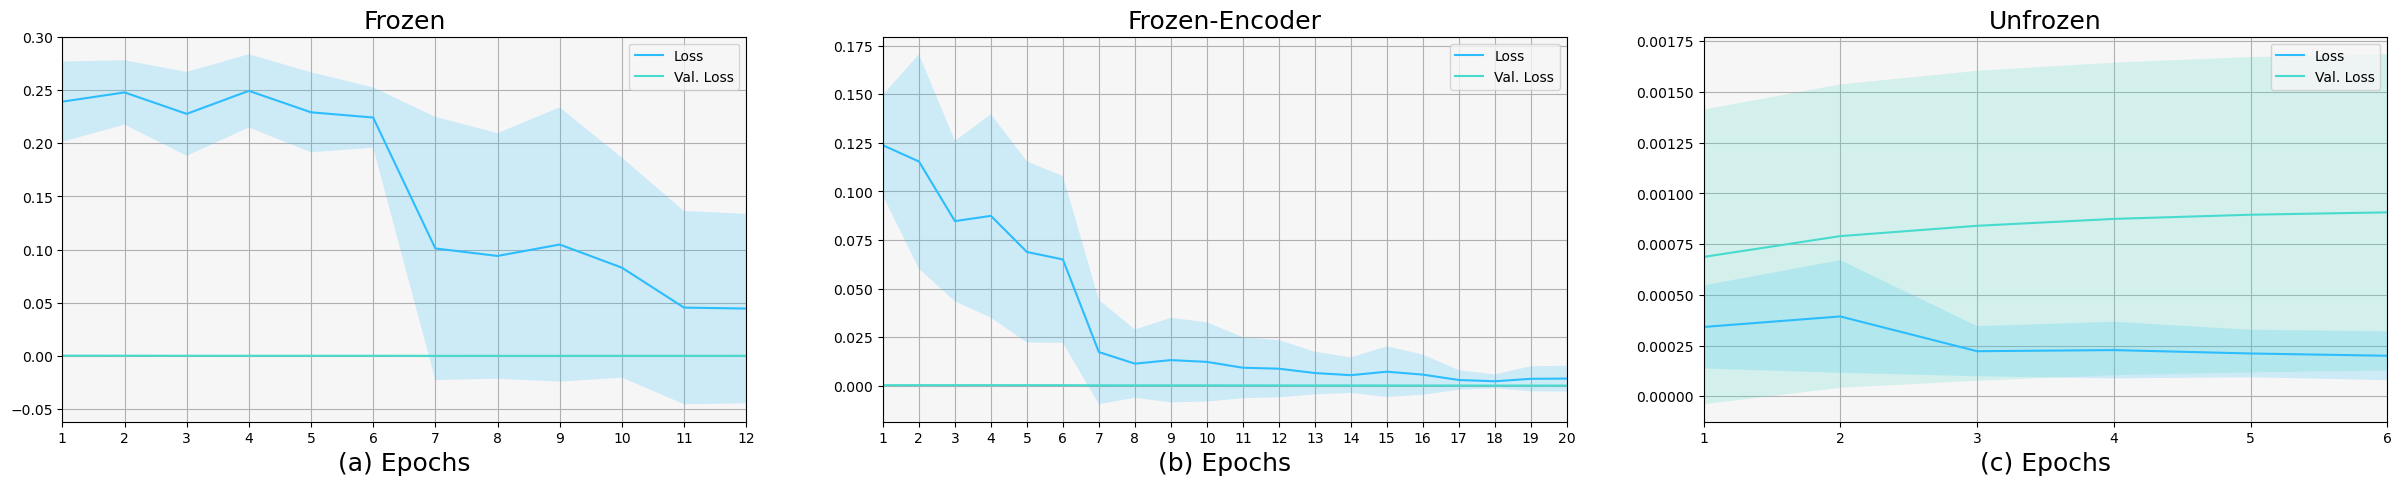

In [23]:
results_path = '../../resources/transfer_learning/output/results/5fold_8020_mask1_unet64f_bce_augmentation'
pre_trained_model = 'Intersection'
fig, axes = plt.subplots(1, len(CONFIGS), figsize=(30,5))

num_epochs = 20
folds = os.listdir(results_path)
num_folds = len(folds)

subfigures = ['a', 'b', 'c', 'd']

total_epochs = []
# for i, config in enumerate(['freeze_all', 'freeze_encoder', 'unfreeze']):
for i, config in enumerate(['freeze_all', 'freeze_encoder', 'unfreeze']):
    mean_loss = np.full((num_folds, num_epochs), 0, dtype=np.float32)
    mean_val_loss = np.full((num_folds, num_epochs), 0, dtype=np.float32)
    
    num_max_epochs = 0
    for j, fold in enumerate(folds):
        history_file = os.path.join(results_path, fold, pre_trained_model, f'{config}_history.json')
        with open(history_file) as f:
            history = json.load(f)
            loss = np.asarray(history['loss'])
            val_loss = np.asarray(history['val_loss'])

        num_max_epochs = max((num_max_epochs, loss.size))
        mean_loss[j, :loss.size] = loss.copy()
        mean_val_loss[j, :val_loss.size] = val_loss.copy()

        total_epochs.append(val_loss.size)

    x_axis = np.arange(1, num_max_epochs+1)
    mean_loss_std = np.nanstd(mean_loss, axis=0)[:num_max_epochs]
    mean_loss_values = np.nanmean(mean_loss, axis=0)[:num_max_epochs]
    axes[i].plot(x_axis, mean_loss_values, label="Loss")
    axes[i].fill_between(x_axis, mean_loss_values-mean_loss_std, mean_loss_values+mean_loss_std, alpha=0.2, linestyle='--')

    mean_val_loss_std = np.nanstd(mean_val_loss, axis=0)[:num_max_epochs]
    mean_val_loss_values = np.nanmean(mean_val_loss, axis=0)[:num_max_epochs]
    axes[i].plot(x_axis, mean_val_loss_values, label="Val. Loss")
    axes[i].fill_between(x_axis, mean_val_loss_values-mean_val_loss_std, mean_val_loss_values+mean_val_loss_std, alpha=0.2, linestyle='--')


    axes[i].set_xticks(x_axis)
    axes[i].set_xlim(1, num_max_epochs)

    axes[i].set_title(LABELS_CONFIG[config], fontsize=18)
    axes[i].set_xlabel(f'({subfigures[i]}) Epochs', fontsize=18)
    axes[i].legend()


In [27]:
df_methods = read_methods_results(METHODS_RESULTS_PATH)

df_methods

,fold,method,P,R,IoU,F-score
0,1,KatoNakamura,0.970317,0.270533,0.268312,0.423101
1,1,Liu,0.524961,0.873542,0.487884,0.655809
2,1,Murphy,0.646545,0.914608,0.609739,0.757562
3,2,KatoNakamura,0.970317,0.270533,0.268312,0.423101
4,2,Liu,0.524961,0.873542,0.487884,0.655809
5,2,Murphy,0.646545,0.914608,0.609739,0.757562
6,3,KatoNakamura,0.970317,0.270533,0.268312,0.423101
7,3,Liu,0.524961,0.873542,0.487884,0.655809
8,3,Murphy,0.646545,0.914608,0.609739,0.757562
9,5,KatoNakamura,0.970317,0.270533,0.268312,0.423101
